In [1]:
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import optuna
from sklearn.model_selection import GridSearchCV
 

In [2]:
color_blue_light = "deepskyblue"
color_blue_vivid = "royalblue"
color_green = "mediumseagreen"
color_pink = "hotpink"
color_gold = "gold"
color_purple = "mediumorchid"
color_orange = "darkorange"
color_mint = "mediumaquamarine"
color_lavender = "blueviolet"
color_sky = "cadetblue"
color_rose = "lightcoral"
color_red = "indianred"
color_black = "black"
color_white = "white"


In [3]:
df = pd.read_csv("data/df_grouped.csv")


In [4]:
df.columns

Index(['Indice di spopolamento', 'Indice di occupazione',
       'Indice disoccupazione',
       'Tipo di località_Altri comuni non altrimenti classificati',
       'Tipo di località_Capoluogo senza specifici interessi turistici',
       'Tipo di località_Città d'Arte', 'Tipo di località_Località collinari',
       'Tipo di località_Località lacuali', 'Tipo di località_Località marine',
       'Tipo di località_Località montane',
       'Tipo di località_Località religiose',
       'Tipo di località_Località termali', 'PC_Economica', 'PC_Metropoli',
       'PC_Diversificata', 'PC_Qualita_Alta', 'PC_Business', 'PC_Balneare',
       'PC_Montano', 'PC_Costiero_Minore', 'PC_Balneare_Massa',
       'PC_Religioso_Culturale', 'PC_Lusso_Termale', 'PC_Enogastronomico',
       'PC_Lacustre_Transito', 'Macroarea_Isole', 'Macroarea_Nord',
       'Macroarea_Sud',
       'Descrizione_Tipologia_di_Immobile_Abitazioni_di_tipo_economico',
       'Descrizione_Tipologia_di_Immobile_Abitazioni_signorili',

In [5]:
# Label encoding for the diagnosis column
le = LabelEncoder()

y = df["Media Costo alla Vendita"]
X = df.drop(columns=["Media Costo alla Vendita"])

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)


# CREAZIONE DI UN LOOP PER TESTARE RANDOM FOREST CON DIVERSO NUMERO DI ALBERI PER TROVARE IL "MIGLIORE"

n_estimators: 50, R2 score: 0.3181
n_estimators: 100, R2 score: 0.3188
n_estimators: 200, R2 score: 0.3176
n_estimators: 300, R2 score: 0.3177
n_estimators: 400, R2 score: 0.3182
n_estimators: 500, R2 score: 0.3182


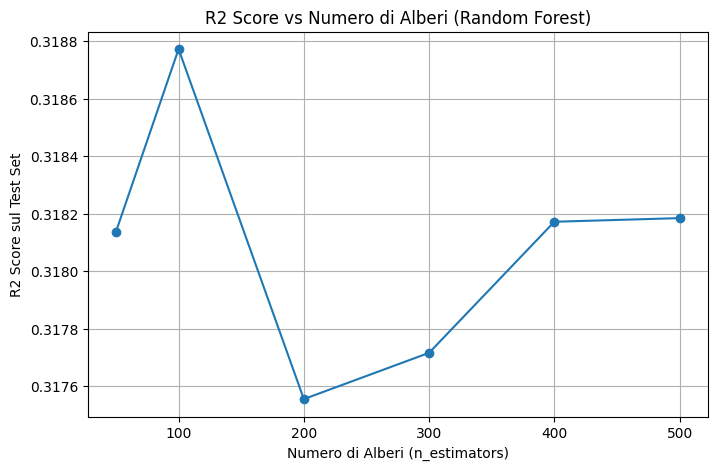

In [6]:
# Lista di numeri di alberi da testare
n_estimators_list = [50, 100, 200, 300, 400, 500]

# Lista per salvare le accuracy
accuracies = []

for n in n_estimators_list:
    rf_regressor = RandomForestRegressor(
        n_estimators=n,
        min_samples_leaf=0.12,
        random_state=1
    )
    
    rf_regressor.fit(X_train, y_train)
    y_pred = rf_regressor.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    
    accuracies.append(r2)
    print(f'n_estimators: {n}, R2 score: {r2:.4f}')

# Plot del grafico
plt.figure(figsize=(8, 5))
plt.plot(n_estimators_list, accuracies, marker='o', linestyle='-')
plt.title('R2 Score vs Numero di Alberi (Random Forest)')
plt.xlabel('Numero di Alberi (n_estimators)')
plt.ylabel('R2 Score sul Test Set')
plt.grid(True)
plt.show()



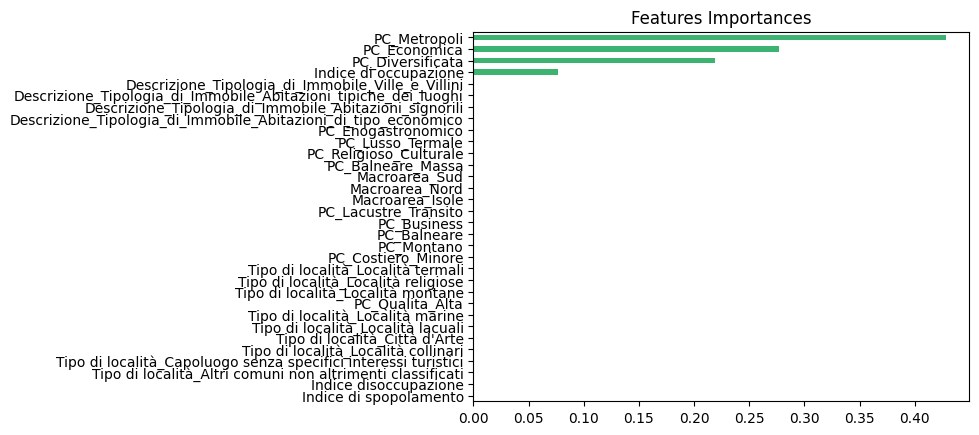

In [7]:
# Create a pd.Series of features importances
importances = pd.Series(data=rf_regressor.feature_importances_,
                        index= X_train.columns)

# Sort importances
importances_sorted = importances.sort_values()

# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color=color_green)
plt.title('Features Importances')
plt.show()

# GRID SEARCH

In [8]:
# The hyperparameters
rf_regressor.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 0.12,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 500,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

In [9]:
params_rf = {
    'n_estimators': [100, 200, 500],
    'max_features': ['log2', 'sqrt'],
    'min_samples_leaf': [1, 5, 10]
}


In [10]:
rf = RandomForestRegressor(random_state=1)

grid_rf = GridSearchCV(estimator=rf,
                       param_grid=params_rf,
                       cv=5,
                       scoring='neg_mean_squared_error',
                       n_jobs=-1)

grid_rf.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=1), n_jobs=-1,
             param_grid={'max_features': ['log2', 'sqrt'],
                         'min_samples_leaf': [1, 5, 10],
                         'n_estimators': [100, 200, 500]},
             scoring='neg_mean_squared_error')

In [11]:
# Extract the best estimator
best_model = grid_rf.best_estimator_

# Predict test set labels
y_pred = best_model.predict(X_test)

# Compute metrics
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

# Print results
print('Test R² of best model: {:.3f}'.format(r2))
print('Test RMSE of best model: {:.3f}'.format(rmse))
print('Test MAE of best model: {:.3f}'.format(mae))
print('Best hyperparameters:', grid_rf.best_params_)


Test R² of best model: 0.616
Test RMSE of best model: 458.430
Test MAE of best model: 261.870
Best hyperparameters: {'max_features': 'log2', 'min_samples_leaf': 1, 'n_estimators': 500}


## Test R² = 0.616 
il modello riesce a spiegare il 61,6% della variabilità del prezzo delle case

## Test RMSE (Root Mean Squared Error) è l'errore quadratico medio = 458.430
in media, le previsioni del tuo modello si discostano di circa 458 euro dal valore reale. Questo numero può essere buono o meno a seconda dell’intervallo di prezzo delle case.

## Test MAE (Mean Absolute Error) è l’errore medio assoluto = 261.870
in media, il modello sbaglia di circa 262 euro per ogni previsione. È un valore più “concreto” da interpretare rispetto all’RMSE.


In [12]:
prezzo_min = df['Media Costo alla Vendita'].min()
prezzo_max = df['Media Costo alla Vendita'].max()

print(f"Il prezzo minimo è {prezzo_min:.2f} euro")
print(f"Il prezzo massimo è {prezzo_max:.2f} euro")


Il prezzo minimo è 0.00 euro
Il prezzo massimo è 13450.00 euro


Abbiamo analizzato un database immobiliare con l’obiettivo iniziale di prevedere il prezzo delle case. Dopo un’esplorazione approfondita e diverse trasformazioni dei dati, abbiamo costruito un modello di Random Forest che ci ha restituito un R² di 0.616: questo significa che il modello riesce a spiegare circa il 62% della variabilità del prezzo.

I risultati mostrano un errore medio assoluto di circa 260 euro. Per dare un’idea concreta, i prezzi nel nostro dataset vanno da 0 a 13.450 euro, quindi l’errore del modello è molto contenuto rispetto all’intervallo totale dei valori.

Infine, anche se la previsione del prezzo era il nostro obiettivo iniziale, abbiamo scoperto che le relazioni tra variabili socio-economiche e tipologie immobiliari erano ancora più interessanti, e abbiamo usato tecniche come PCA e clustering per esplorarle.